1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [39]:
import pandas as pd 
import numpy as np
import seaborn as sns

nrows = 35000
df = pd.read_csv("./data_000637.txt", nrows = nrows)
df


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
34995,1,0,47,3869200515,2127,20
34996,1,0,80,3869200515,2128,19
34997,1,0,48,3869200515,2123,8
34998,1,1,48,3869200515,2285,16


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
a = 0
b = 0
for i in range(len(df)):
    if df.iloc[i,4] > a:
        a = df.iloc[i,4]
        b = i
    elif df.iloc[i,4] == 0:
        break
    else:
        continue


# max value for row = 2893 BX_Counter max value = 3563+1
print("all rows and colums for max value for BX_Counter :\n",df.iloc[b])
max_BX = df.iloc[b,4]
estimated_BX = max_BX + 1
print("\nEstimated BX number:", estimated_BX)
print("\nOrbit value is:", df.iloc[b,3])

all rows and colums for max value for BX_Counter :
 HEAD                    1
FPGA                    0
TDC_CHANNEL            45
ORBIT_CNT      3869200195
BX_COUNTER           3563
TDC_MEAS               29
Name: 2893, dtype: int64

Estimated BX number: 3564

Orbit value is: 3869200195


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [6]:
df_TDC = df["TDC_MEAS"]
estimated_TDC =  max(df_TDC) + 1

df_ORBIT = df["ORBIT_CNT"]

min_ORBIT = min(df_ORBIT)
values_with_min_orbit = df.loc[df['ORBIT_CNT'] == min_ORBIT]
min_BX_min_orbit = min(values_with_min_orbit["BX_COUNTER"])
values_with_min_bx = values_with_min_orbit.loc[values_with_min_orbit['BX_COUNTER'] == min_BX_min_orbit]
min_TDC_min_bx = min(values_with_min_bx["TDC_MEAS"])

max_ORBIT = max(df_ORBIT)
values_with_max_orbit = df.loc[df['ORBIT_CNT'] == max_ORBIT]
max_BX_max_orbit = max(values_with_max_orbit["BX_COUNTER"])
values_with_max_bx = values_with_max_orbit.loc[values_with_max_orbit['BX_COUNTER'] == max_BX_max_orbit]
max_TDC_max_bx = max(values_with_max_bx["TDC_MEAS"])

starting_point_ns = (min_ORBIT*estimated_BX + min_BX_min_orbit) * 25 + min_TDC_min_bx * 25/30
df['NS_PASSED'] = ((df['ORBIT_CNT']*estimated_BX + df['BX_COUNTER']) * 25 + df['TDC_MEAS']* 25/30) - starting_point_ns
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NS_PASSED
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29,1.773438e+07
19996,1,0,63,3869200366,2517,6,1.773446e+07
19997,1,0,32,3869200366,2519,5,1.773451e+07
19998,1,0,17,3869200366,2522,21,1.773460e+07


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [ ]:
print("Starting orbit: ", min_ORBIT, "Starting BX: ", min_BX_min_orbit, "Starting TDC: ", min_TDC_min_bx)
print("Ending orbit: ", max_ORBIT, "Ending BX: ", max_BX_max_orbit, "Ending TDC: ", max_TDC_max_bx)

total_bx = (estimated_BX - min_BX_min_orbit) + max_BX_max_orbit + ((max_ORBIT - min_ORBIT)*estimated_BX)
fragment_tdc = max_TDC_max_bx + (estimated_TDC - min_TDC_min_bx)
print("Total Passed Time: ", total_bx, "  BX  +  ", fragment_tdc, " TDC")
print("Total Passed Time in NS: ", total_bx*25 + fragment_tdc*(25/30))
print("Total Passed Time in seconds: ", (total_bx*25 + fragment_tdc*(25/30))*1e-9)

5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [ ]:
group_tdc = df.groupby('TDC_CHANNEL').sum().sort_values(by = ['HEAD']).iloc[-3:]
top = [3, 2, 1]
group_tdc['TOP'] = top
group_tdc


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [22]:
orbits_with_hit = len(df.groupby('ORBIT_CNT').size())
print("Non-empty orbits:", orbits_with_hit)

Non-empty orbits: 200


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [18]:
count = len(df[df['TDC_CHANNEL']==139].groupby('ORBIT_CNT').count())
print("Number of unique orbits with at least one measurement from TDC channel 139 is",count)

Number of unique orbits with at least one measurement from TDC channel 139 is 200


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [10]:
firFPGA = pd.Series(df[df['FPGA'] == 0]['TDC_CHANNEL'].value_counts())
secFPGA = pd.Series(df[df['FPGA'] == 1]['TDC_CHANNEL'].value_counts())
print(firFPGA)
print(secFPGA)

139    1171
64      975
63      961
61      726
62      711
       ... 
107       6
106       6
98        5
101       3
67        2
Name: TDC_CHANNEL, Length: 118, dtype: int64
139    522
2      479
1      435
4      393
3      362
      ... 
78       1
86       1
93       1
76       1
91       1
Name: TDC_CHANNEL, Length: 125, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

<AxesSubplot: xlabel='TDC_CHANNEL', ylabel='Count'>

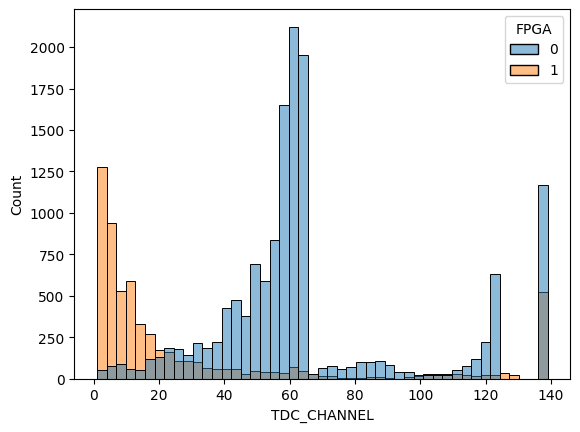

In [38]:
sns.histplot(data=df, x="TDC_CHANNEL", hue="FPGA")
